In [2]:
# Libraries

# Base Functionalities
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import numpy as np
import os
import cv2
import time
from random import randint
import SimpleITK as sitk
import pandas as pd
import sys

# CNN Libraries
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
from keras.layers.core import Dropout
import tensorflow as tf
# from tensorflow.keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Visualisation Libraries
import plotly.graph_objects as go
import pydicom
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Mask Creation Libraries
import trimesh
# import pyvista as pv
from PIL import Image
# from stl import mesh
from skimage import measure
from skimage.transform import resize
from plyfile import PlyData
from pyntcloud import PyntCloud

# Viewer
from scipy import ndimage as ndi
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
# import napari 
from matplotlib.widgets import Slider

Height and Width of Single MRI Scan:  (512, 512)


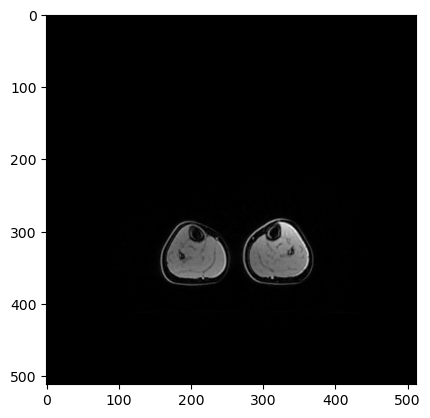

{'X': '-239.53125', 'Y': '-239.53125', 'Z': '-1114.5'}


In [2]:
# Understanding the data format

# Read in Diacom file
example_mri_scan_file = pydicom.dcmread("D:/MRI - Tairawhiti/AutoBind_WaterWATER_450_15A/IM-0049-0750.dcm")

# Assessing metadata within Diacom file
example_mri_scan = example_mri_scan_file.pixel_array
example_mri_scan_coordinate_data = example_mri_scan_file.ImagePositionPatient

print('Height and Width of Single MRI Scan: ', example_mri_scan.shape)

plt.imshow(example_mri_scan, cmap='gray')
plt.show()


print({'X': example_mri_scan_coordinate_data[0], 'Y': example_mri_scan_coordinate_data[1], 'Z': example_mri_scan_coordinate_data[2]})

Training Data (MRI Scans) Read-In

In [3]:
# Helper Function
def flatten_3d_to_2d(array_3d):
    # Get the dimensions of the 3D array
    depth, height, width = array_3d.shape
    
    # Reshape the 3D array to a 2D array
    array_2d = np.reshape(array_3d, (depth, height * width))
    
    return array_2d

# Helper Function
def flatten_2d_array(arr):
    flattened = []
    for row in arr:
        flattened.extend(row)
    return flattened
    
# Helper Function
# Read in entire scan of single patient
# folders = [f for f in os.listdir('MRI Scans - Tairawhiti') if os.path.isdir(os.path.join('MRI Scans - Tairawhiti', f))]
def ListFolders(directory):
    folder_names = []
    for root, dirs, files in os.walk(directory):
        for folder in dirs:
            folder_names.append(folder)
    return folder_names

# Helper Function
def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.endswith('.dcm'):
            try:
                dicom_file = pydicom.dcmread(filepath)
                dicom_files.append(dicom_file)
            except pydicom.errors.InvalidDicomError:
                print(f"Skipping file: {filename}. It is not a valid DICOM file.")
    return dicom_files

# Helper Function
def get_ram_usage(variable):
    print("Memory usage of my_list:", get_ram_usage(variable))

def TrainingMRIScans(scans_path):

    folders = ListFolders(scans_path)
    scan_pixel_data = []
    scan_coordinate_data = []

    # Pixel Data
    for paitent in folders:
        single_scan_pixel_data = []
        # single_scan_coord_data = []
        single_paitent_scans_path =  scans_path + '/{}'.format(paitent)
        dicom_files = read_dicom_files(single_paitent_scans_path)
        # D:\MRI - Tairawhiti\AutoBind_WaterWATER_450
        for i in range (len(dicom_files)):
            single_scan_pixel_data.append(dicom_files[i].pixel_array)
            # single_scan_coord_data.append(dicom_files[i].ImagePositionPatient)
        scan_pixel_data.append(single_scan_pixel_data)
        # scan_coordinate_data.append(single_scan_pixel_data)

    training_scans = flatten_2d_array(scan_pixel_data)
    training_scans = np.array(training_scans)
    #TEMP
    training_scans = training_scans[0:1015]

    # Coordinate Data
    for paitent in folders:
        single_paitent_scans_path =  scans_path + '/{}'.format(paitent)
        for i in range (len(dicom_files)):
            scan_coordinate_data.append(dicom_files[i].ImagePositionPatient)
    coord_data = pd.DataFrame(scan_coordinate_data, columns=["x", "y", "z"])
    coord_data = coord_data[0:1015]
    # scan_coordinate_data = flatten_2d_array(scan_coordinate_data)
    # scan_coordinate_data = np.array(scan_coordinate_data)

    return training_scans, coord_data

Mapping Coordinate Data from MRI Scans to Mask

In [4]:
# Mapping coordinate data from groundtruth mask/label to mri training data

def MappingCoordinateData(filename_label, coord_data):
    # Load in mesh of label data
    mesh = trimesh.load_mesh(('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/{}.ply').format(filename_label))

    # Convert the mesh vertices to a DataFrame
    vertices = pd.DataFrame(mesh.vertices, columns=["x", "y", "z"])

    print('Height of Paitent in mm: ', np.abs(coord_data.iloc[-1][2] - coord_data.iloc[0][2]))
    print('Length of Paitent AOI (tibia) in mm: ', np.abs(vertices.iloc[-1][2] - vertices.iloc[0][2]))

    vertices['z'] = np.round(vertices['z'] * 2) / 2
    coord_data['z'] = np.round(coord_data['z'] * 2) / 2

    merged_df = pd.merge(coord_data, vertices, on='z')
    condensed_df = merged_df.groupby('z').mean().reset_index()

    mapping_dict = dict(zip(condensed_df['z'], ['AOI']*len(condensed_df)))

    coord_data['SegmentationRegionSlice'] = coord_data['z'].map(mapping_dict).fillna('Outside of AOI')

    slices_aoi_start = (coord_data.loc[coord_data['SegmentationRegionSlice'] == 'AOI'].index)[0]
    slices_aoi_end = (coord_data.loc[coord_data['SegmentationRegionSlice'] == 'AOI'].index)[-1]
    slice_aoi_range = (slices_aoi_end - slices_aoi_start + 1)
    print('AOI Slice Start: ', slices_aoi_start)
    print('AOI Slice End: ', slices_aoi_end)
    print('AOI Slice Range: ', slice_aoi_range)

    # CSV Format 
    if False:
        coord_data.to_csv('tibia_mri_coord.csv')

    return slices_aoi_start, slices_aoi_end, slice_aoi_range, coord_data

In [27]:
coord_data
coord_data.loc[coord_data['SegmentationRegionSlice'] == 'AOI']

,x,y,z,SegmentationRegionSlice
661,-239.53125,-239.53125,-982.0,AOI
662,-239.53125,-239.53125,-983.5,AOI
663,-239.53125,-239.53125,-985.0,AOI
664,-239.53125,-239.53125,-986.5,AOI
665,-239.53125,-239.53125,-988.0,AOI
...,...,...,...,...
866,-239.53125,-239.53125,-1290.5,AOI
867,-239.53125,-239.53125,-1292.0,AOI
868,-239.53125,-239.53125,-1293.5,AOI
869,-239.53125,-239.53125,-1295.0,AOI


In [184]:
merged_df

,x_x,y_x,z,SegmentationRegionSlice,x_y,y_y
0,-239.53125,-239.53125,-1016.5,AOI,59.30024,47.23241
1,-239.53125,-239.53125,-1016.5,AOI,58.33960,47.93643
2,-239.53125,-239.53125,-1016.5,AOI,57.52317,47.46100
3,-239.53125,-239.53125,-1016.5,AOI,57.42165,48.60093
4,-239.53125,-239.53125,-1016.5,AOI,56.56377,47.86691
...,...,...,...,...,...,...
8284,-239.53125,-239.53125,-1331.0,AOI,34.13574,54.72699
8285,-239.53125,-239.53125,-1331.0,AOI,32.61208,55.19926
8286,-239.53125,-239.53125,-1331.0,AOI,33.54550,55.19661
8287,-239.53125,-239.53125,-1331.0,AOI,33.97592,55.83883


In [185]:
condensed_df

,z,x_x,y_x,x_y,y_y
0,-1331.0,-239.53125,-239.53125,33.436536,54.454491
1,-1329.5,-239.53125,-239.53125,33.496050,55.140409
2,-1328.0,-239.53125,-239.53125,34.388937,58.269135
3,-1326.5,-239.53125,-239.53125,34.281061,57.147482
4,-1325.0,-239.53125,-239.53125,37.547432,60.972992
...,...,...,...,...,...
199,-1022.5,-239.53125,-239.53125,59.608529,44.706527
200,-1021.0,-239.53125,-239.53125,59.390898,43.709025
201,-1019.5,-239.53125,-239.53125,60.397116,43.997957
202,-1018.0,-239.53125,-239.53125,60.650788,49.762837


In [26]:
coord_data.loc[coord_data['z'] == -1200.0]
# coord_data.loc[coord_data['z'] == -1016.5]

,x,y,z,SegmentationRegionSlice
806,-239.53125,-239.53125,-1200.0,AOI


Mask (Groundtruth label) 

In [5]:
def VoxelisationMask(filename_label, slice_aoi_range):
    # Load in mesh of label data
    mesh = trimesh.load_mesh(('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/{}.ply').format(filename_label))

    # Convert the mesh vertices to a DataFrame
    vertices = pd.DataFrame(mesh.vertices, columns=["x", "y", "z"])

    # Convert the mesh to a PyntCloud object
    cloud = PyntCloud(vertices)

    # Set the desired resolution
    desired_resolution = [slice_aoi_range, 512, 512]

    # Voxelize the mesh using the PyntCloud voxelization module
    voxelgrid_id = cloud.add_structure("voxelgrid", n_x=desired_resolution[0], n_y=desired_resolution[1], n_z=desired_resolution[2])
    voxel_grid = cloud.structures[voxelgrid_id].get_feature_vector().reshape(desired_resolution)

    # Transpose and swap axes to change the voxel grid orientation
    voxel_grid = np.transpose(voxel_grid, axes=(2, 0, 1))

    # Resize the voxel grid to match the desired dimensions
    voxel_grid = resize(voxel_grid, desired_resolution, anti_aliasing=False)

    voxel_grid = np.where(voxel_grid > 0, 1, 0)

    print('Mask Slices Normalized to MRI Scans Shape (Purely AOI)', voxel_grid.shape)

    return voxel_grid


def get_ram_usage(variable):
    print("Memory usage of my_list:", get_ram_usage(variable))

In [ ]:
def get_ram_usage(variable):
    print("Memory usage of my_list:", get_ram_usage(variable))

Train Scans & Mask Creation

In [1]:
# \\files.auckland.ac.nz\research\resmed202100086-tws ----> Address for raw data
scans_path = 'D:/MRI - Tairawhiti'
# filename_labels = ['R_tibia_15A', 'R_tibia_16A', 'R_tibia_4A']
filename_labels = ['R_tibia_15A']
train_mask_tibia_labels, training_scans, start_slices_aoi, end_slices_aoi, slice_aoi_ranges  = [], [], [], [], []

for filename_label in filename_labels:
    print(('{}'.format(filename_label)))

    training_scan, coord_data = TrainingMRIScans(scans_path)
    slices_aoi_start, slices_aoi_end, slice_aoi_range, coord_data = MappingCoordinateData(filename_label, coord_data)
    voxel_grid = VoxelisationMask(filename_label, slice_aoi_range)

    train_mask_tibia = np.zeros((1015, 512, 512))
    train_mask_tibia[(slices_aoi_start):(slices_aoi_end+1)] = voxel_grid
    train_mask_tibia_labels.append(train_mask_tibia)

    training_scans.append(training_scan)

    start_slices_aoi.append(slices_aoi_start)
    end_slices_aoi.append(slices_aoi_end)
    slice_aoi_ranges.append(slice_aoi_range)

    print('\n')

max_slice_aoi_range = np.max(slice_aoi_ranges)
min_start_slice_aoi = np.min(start_slices_aoi)
max_end_slice_aoi = np.max(end_slices_aoi)

for patient in range(len(train_mask_tibia_labels)):
    train_mask_tibia_labels[patient] = train_mask_tibia_labels[patient][min_start_slice_aoi:max_end_slice_aoi]
    training_scans[patient] = training_scans[patient][min_start_slice_aoi:max_end_slice_aoi]

train_mask_tibia_labels = np.array(train_mask_tibia_labels)
training_scans = np.array(training_scans)

# Determines image dataset size for UNet model
# training_scans_reshape = train_mask_tibia_labels.reshape((1, 10, 512, 512))
# train_mask_tibia_labels_reshape = training_scans.reshape((1, 10, 512, 512))
training_scans_reshape = training_scans[:10]
train_mask_tibia_labels_reshape = train_mask_tibia_labels[:10]

# Free up memory occupied by the original arrays
%reset_selective -f training_scans 
%reset_selective -f train_mask_tibia_labels 
training_scans = training_scans_reshape
train_mask_tibia_labels = train_mask_tibia_labels_reshape
%reset_selective -f training_scans_reshape 
%reset_selective -f train_mask_tibia_labels_reshape 


print('Number of Paitents: ', (training_scans.shape)[0])
print('Training Scans Input Shape: ', training_scans.shape)
print('Training Masks Input Shape: ', train_mask_tibia_labels.shape)
get_ram_usage(training_scans)
get_ram_usage(train_mask_tibia_labels)

R_tibia_15A


NameError: name 'TrainingMRIScans' is not defined

In [ ]:
hi = 5
del hi

: 

Slice Visualiser Tools

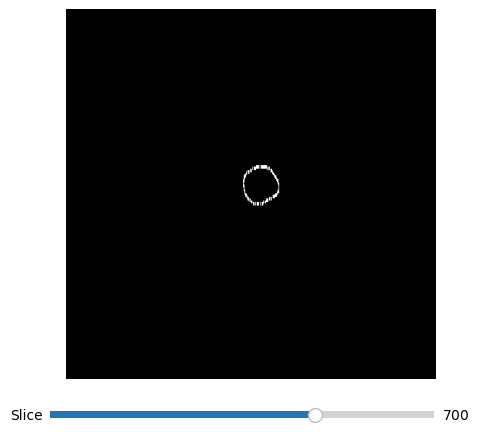

In [23]:
# Visualiser Tool
fig, ax = plt.subplots()
current_slice = 700
paitent = 1
# img = ax.imshow(training_scans[current_slice], cmap='gray')
img = ax.imshow(train_mask_tibia_labels[paitent-1][current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, train_mask_tibia_labels.shape[1] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(train_mask_tibia_labels[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

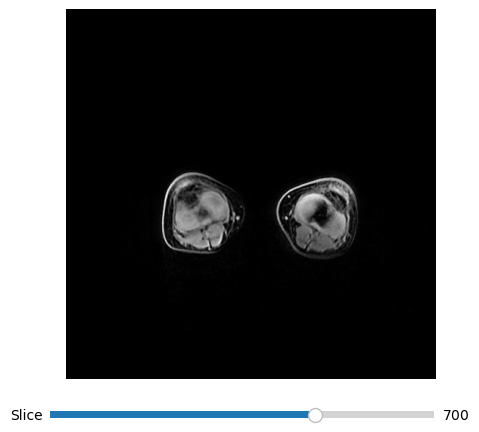

In [20]:
# Visualiser Tool
fig, ax = plt.subplots()
current_slice = 700
paitent = 1
# img = ax.imshow(training_scans[current_slice], cmap='gray')
img = ax.imshow(training_scans[paitent - 1][current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, training_scans.shape[1] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(training_scans[paitent - 1][current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

In [136]:
# def load_ply_file(file_path):
#     mesh = trimesh.load_mesh(file_path)
#     vertices = np.asarray(mesh.vertices)
#     return vertices

# def preprocess_data(mri_scans, tibia_mask):
#     # Resize MRI scans to match the dimensions of the tibia mask
#     mri_scans_resized = []
#     for scan in mri_scans:
#         resized_scan = resize(scan, tibia_mask.shape[:2], anti_aliasing=True)
#         mri_scans_resized.append(resized_scan)
#     mri_scans_resized = np.array(mri_scans_resized)

#     # Normalize the intensity values of MRI scans to the range [0, 1]
#     mri_scans_normalized = (mri_scans_resized - np.min(mri_scans_resized)) / (np.max(mri_scans_resized) - np.min(mri_scans_resized))

#     # Binarize the tibia mask by setting all non-zero values to 1
#     tibia_mask_binarized = np.where(tibia_mask > 0, 1, 0)

#     return mri_scans_normalized, tibia_mask_binarized


# # tibia_mask = load_ply_file('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/R_tibia_15A.stl')
# mri_scans_normalized, tibia_mask_binarized = preprocess_data(example_mri_scan, tibia_mask)

In [20]:
training_scans.shape

(3, 236, 512, 512)

In [21]:
train_mask_tibia_labels.shape

(3, 236, 512, 512)

Model Architecture

In [8]:
# Define U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Dice Coefficient Loss Function 
def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice


# # Set the input shape of your MRI scans
# # input_shape = (1015, 512, 512, 1)
# input_shape = (512, 512, 1)

# # Load and preprocess your MRI scan dataset and corresponding labels
# train_single_scan = training_scans[0][700]
# train_single_label = train_mask_tibia_labels[0][700]
# train_single_scan = train_single_scan.reshape(-1, 512, 512, 1)
# train_single_label = train_single_label.reshape(-1, 512, 512, 1)
# # training_scan_model = [training_scans[0], training_scans[1], training_scans[2]]
# # training_label_model = [train_mask_tibia_labels[0], train_mask_tibia_labels[1], train_mask_tibia_labels[2]]
# # training_scan_model = np.array(training_scan_model).reshape(1015, 512, 512, 3)
# # training_label_model = np.array(training_label_model).reshape(1015, 512, 512, 3)

# validation_single_scan = training_scans[1][700]
# validation_single_label = train_mask_tibia_labels[1][700]
# validation_single_scan = validation_single_scan.reshape(-1, 512, 512, 1)
# validation_single_label = validation_single_label.reshape(-1, 512, 512, 1)
# # validation_scan_model = [training_scans[0]]
# # validation_label_model = [train_mask_tibia_labels[0]]
# # validation_scan_model = np.array(validation_scan_model).reshape(1015, 512, 512, 1)
# # validation_label_model = np.array(validation_label_model).reshape(1015, 512, 512, 1)

# test_single_scan = training_scans[2][700]
# test_single_label = train_mask_tibia_labels[2][700]
# test_single_scan = test_single_scan.reshape(-1, 512, 512, 1)
# test_single_label = test_single_label.reshape(-1, 512, 512, 1)
# # test_scan_model = [training_scans[1]]
# # test_label_model = [train_mask_tibia_labels[1]]
# # test_scan_model = np.array(test_scan_model).reshape(1015, 512, 512, 1)
# # test_label_model = np.array(test_label_model).reshape(1015, 512, 512, 1)

# unseen_single_scan = training_scans[0][701]
# unseen_single_label = train_mask_tibia_labels[0][701]
# unseen_single_scan = unseen_single_scan.reshape(-1, 512, 512, 1)
# unseen_single_label = unseen_single_label.reshape(-1, 512, 512, 1)
# # unseen_scan_model = [training_scans[2]]
# # unseen_label_model = [train_mask_tibia_labels[2]]
# # unseen_scan_model = np.array(unseen_scan_model).reshape(1015, 512, 512, 1)
# # test_label_model = test_label_model.reshape(1015, 512, 512, 1)

# input_shape = (512, 512, 1)  # For grayscale images


# training_scan_model = [training_scans[0], training_scans[1], training_scans[2]]
# training_label_model = [train_mask_tibia_labels[0], train_mask_tibia_labels[1], train_mask_tibia_labels[2]]
# # training_scan_model = np.array(training_scan_model).reshape(1015, 512, 512, 3)
# # training_label_model = np.array(training_label_model).reshape(1015, 512, 512, 3)

# validation_scan_model = [training_scans[0]]
# validation_label_model = [train_mask_tibia_labels[0]]
# # validation_scan_model = np.array(validation_scan_model).reshape(1015, 512, 512, 1)
# # validation_label_model = np.array(validation_label_model).reshape(1015, 512, 512, 1)

# test_scan_model = [training_scans[1]]
# test_label_model = [train_mask_tibia_labels[1]]
# # test_scan_model = np.array(test_scan_model).reshape(1015, 512, 512, 1)
# # test_label_model = np.array(test_label_model).reshape(1015, 512, 512, 1)

# unseen_scan_model = [training_scans[2][100]]
# # unseen_label_model = [train_mask_tibia_labels[2]]
# # unseen_scan_model = np.array(unseen_scan_model).reshape(1015, 512, 512, 1)
# # test_label_model = test_label_model.reshape(1015, 512, 512, 1)


# Reformat image data structure
training_scans_reshaped = np.concatenate(training_scans, axis=0)
training_scans = training_scans_reshaped.reshape((-1, 512, 512, 1))
train_mask_tibia_labels_reshaped = np.concatenate(train_mask_tibia_labels, axis=0)
train_mask_tibia_labels = train_mask_tibia_labels_reshaped.reshape((-1, 512, 512, 1))

# Split the data into training and validation sets\
images_train, images_val, labels_train, labels_val = train_test_split(training_scans, train_mask_tibia_labels, test_size=0.2, random_state=0)
unseen_scan_model = [training_scans[2][100]]

# Expand dimensions for the channel (grayscale) dimension
images_train = np.expand_dims(images_train, axis=-1)
images_val = np.expand_dims(images_val, axis=-1)
labels_train = np.expand_dims(labels_train, axis=-1)
labels_val = np.expand_dims(labels_val, axis=-1)

# Create an instance of the U-Net model
input_shape = (512, 512, 1)  # For grayscale images

# Create an instance of the U-Net model
model = unet_model(input_shape)

# Compile the model
# Binary Cross Entropy Loss Function
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Dice Coefficient Loss Function
# model.compile(optimizer=Adam(), loss=dice_coefficient, metrics=['accuracy'])

# Train the model
model.fit(x=images_train, y=labels_train, batch_size=16, epochs=1, validation_data=(images_val, labels_val))
# Evaluate the model
loss, accuracy = model.evaluate(x=images_val, y=labels_val)

# Perform inference on new, unseen MRI scans
predictions = model.predict(unseen_scan_model)

 1/11 [=>............................] - ETA: 1:09:11 - loss: 1.2403 - accuracy: 0.2826

In [37]:
training_scans.shape

(708, 512, 512)

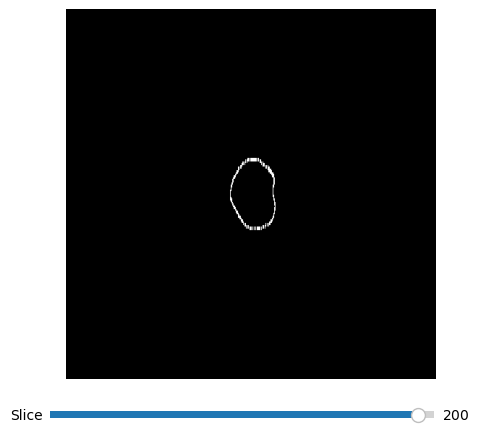

In [17]:
# Visualiser Tool
# voxel_grid_binary, voxel_grid
fig, ax = plt.subplots()
current_slice = 200
# img = ax.imshow(training_scans[current_slice], cmap='gray')
img = ax.imshow(voxel_grid[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, voxel_grid.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(voxel_grid[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

IndexError: index 884 is out of bounds for axis 0 with size 3

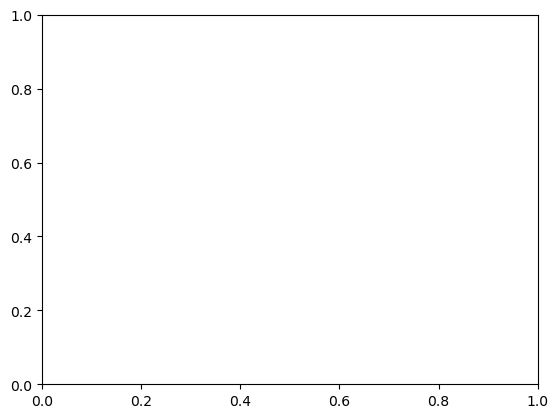

In [18]:
# Visualiser Tool
fig, ax = plt.subplots()
current_slice = 884
# img = ax.imshow(training_scans[current_slice], cmap='gray')
img = ax.imshow(training_scans[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, training_scans.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(training_scans[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

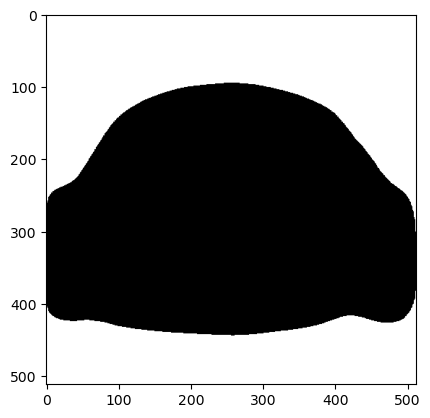

In [39]:
predictions_single_scan = np.reshape(predictions, (512, 512))
predictions_single_scan_binarized = np.where(predictions_single_scan > 0, 1, 0)

plt.imshow(predictions_single_scan_binarized, cmap='gray')
plt.show()

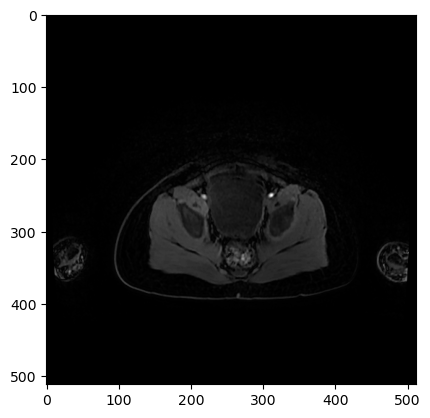

In [77]:
unseen_single_scan_visualise = np.reshape(unseen_single_scan, (512, 512))
# predictions_single_scan_binarized = np.where(predictions_single_scan > 0, 1, 0)

plt.imshow(unseen_single_scan_visualise, cmap='gray')
plt.show()